In [28]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit 
from sklearn.model_selection import train_test_split 

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords #179 stopwords # import nltk, then type nltk.download('stopwords')
from wordcloud import STOPWORDS #192 stopwords

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,LSTM,Dense,Dropout,Bidirectional,Conv1D, MaxPooling1D
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau


# EDA

In [2]:
data = pd.read_csv('DisasterTweet/train.csv')
data

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


### Missing values

In [3]:
missing = (data.isnull().sum()/len(data)*100).round(2)
pd.DataFrame({'% missing values': missing})

,% missing values
id,0.00
keyword,0.80
location,33.27
text,0.00
target,0.00


### Remove unnecessary columns

In [4]:
#I'm removing keyword and location 
data.drop(['id','keyword','location'], axis=1, inplace = True) 

Although 'keywords' doesnt have alot of missing values, I'm dropping it because I dont think I will need it as an additional input. Text alone should be fine. Maybe in the future I might consider including keywords

### Total number of words in each tweet

In [5]:
#find length of each tweet in disaster and non disaster
data_len_0 = data[data['target']==0]['text'].str.split().map(lambda x: len(x))
data_len_1 = data[data['target']==1]['text'].str.split().map(lambda x: len(x)) 

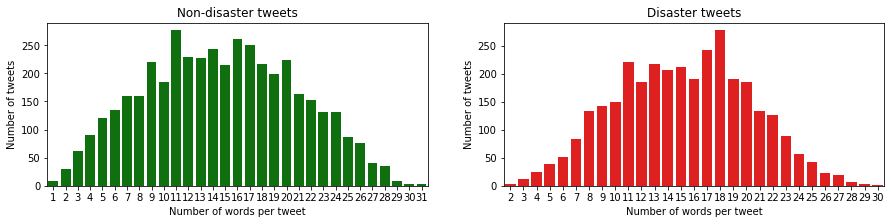

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(15,3))

sns.countplot(data_len_0, ax=axes[0], color='green')
axes[0].set(xlabel='Number of words per tweet', ylabel='Number of tweets', title='Non-disaster tweets')

sns.countplot(data_len_1, ax=axes[1], color='red')
axes[1].set(xlabel='Number of words per tweet', ylabel='Number of tweets', title='Disaster tweets')

plt.show()

The distribution looks similar between disaster and non-disaster tweets. The number of words in majority of the tweets is around 11-17. Only a few are at the 30-31 range. Thus, I will set maxlen=35 when I'm padding the data

### Create training and validation sets

In [7]:
# Create validation set, stratified based on target class distribution
s = StratifiedShuffleSplit(test_size=0.1, random_state=42)

for train_index, val_index in s.split(data, data["target"]): 
    train = data.loc[train_index]
    val = data.loc[val_index]
    
train.reset_index(inplace=True, drop=True) 
val.reset_index(inplace=True, drop=True) 

# Data Cleaning

In [8]:
def clean(text):
    
    text = text.lower()

    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = pattern.sub('', text)    
    
    text = re.sub(r",.\"!@#$%^&*(\\)[\\]{\\}?/;`~:|<>+=-", "", text)

    # Contractions
    text = re.sub(r"ain't", "am not", text)
    text = re.sub(r"aren't", "are not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"could've", "could have", text)
    text = re.sub(r"didn't", "did not", text)
    text = re.sub(r"doesn't", "does not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"hasn't", "has not", text)
    text = re.sub(r"haven't", "have not", text)
    text = re.sub(r"he'll", "he will", text)
    text = re.sub(r"here's", "here is", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"i'd", "i would", text)
    text = re.sub(r"i'll", "i will", text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"isn't", "is not", text)
    text = re.sub(r"it'll", "it will", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"i've", "i have", text)
    text = re.sub(r"let's", "let us", text)
    text = re.sub(r"shouldn't", "should not", text)
    text = re.sub(r"should've", "should have", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"there's", "there is", text)
    text = re.sub(r"they'd", "they would", text)
    text = re.sub(r"they'll", "they will", text)
    text = re.sub(r"they're", "they are", text)
    text = re.sub(r"they've", "they have", text)
    text = re.sub(r"wasn't", "was not", text)
    text = re.sub(r"we'd", "we would", text)
    text = re.sub(r"we'll", "we will", text)
    text = re.sub(r"we're", "we are", text)
    text = re.sub(r"weren't", "were not", text)
    text = re.sub(r"we've", "we have", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"who's", "who is", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"wouldn't", "would not", text)
    text = re.sub(r"would've", "would have", text)
    text = re.sub(r"y'all", "you all", text)
    text = re.sub(r"you'd", "you would", text)
    text = re.sub(r"you'll", "you will", text)
    text = re.sub(r"you're", "you are", text)
    text = re.sub(r"you've", "you have", text)
           
    return text

### Clean training set

In [9]:
train_clean = train.copy()
train_clean['text'] = train_clean['text'].apply(lambda series : clean(series))

In [10]:
df = train_clean["text"].str.find('amp')

In [11]:
df

0       -1
1       -1
2       41
3       -1
4       -1
        ..
6846    -1
6847    -1
6848    -1
6849    -1
6850    -1
Name: text, Length: 6851, dtype: int64

In [12]:
df[df!= -1].index

Int64Index([   2,   40,   53,   73,   78,  119,  179,  180,  185,  209,
            ...
            6691, 6695, 6720, 6741, 6748, 6771, 6772, 6800, 6803, 6815],
           dtype='int64', length=374)

# Data Preprocessing

### Prepare corpus for training set

In [13]:
stopNLTK = set(stopwords.words('english')) # stop words from NLTK
stopWORDCLOUD = set(STOPWORDS) # stopwords from WORDCLOUD
stop_words = stopNLTK | stopWORDCLOUD # combine all of the unique stopwords from NLTK and WORDCLOUD

# create a corpus without stop words and non-alphabet-words
def create_corpus(df):
    corpus = []
    for sentence in df['text']:
        words = []
        for word in word_tokenize(sentence): #word_tokenize splits a sentence into individual words. Useful for removing stop words and non-alphabet words
            if((word.isalpha()==1) & (word not in stop_words)):
                words.append(word)
        corpus.append(words)
    return corpus # returns a list

In [14]:
train_corpus = create_corpus(train_clean) # prepared a complete text containing proper words, which will be tokenized and padded

### Tokenize and pad training set

In [15]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_corpus) # tokenize (split the corpus into individual words) and assign an index based on word frequency

train_sequences = tokenizer.texts_to_sequences(train_corpus) # converts each word in each tweet into numbers
maxlength = 35 
train_padded = pad_sequences(train_sequences, maxlen = maxlength, truncating='post', padding='post') #makes each sentence the same length by padding, or truncating at the end of the sentence

### Create embedding dictionary from pre-trained GloVe model

In [16]:
# this cell creates the embedding DICT which reads from the glove file that contains 400k unique words and its corresponding vectors 
# when you create the embedding MATRIX later, you will refer to this dictionary to get the vectors for the words 

embedding_dict = {}
word_list = []

with open('glove_6B_100d.txt','r', encoding = "utf-8") as g: 
    for line in g: # each 'line' is a string which contains a WORD and its corresponding VECTOR (which contains 100 numbers, because 100 dimensions)
        values = line.split() # .split() will split a 'line' string into a list, in which the first item is the WORD, the next 100 items are the 100 numbers
        word = values[0] # get the WORD
        word_list.append(word)
        vector = np.asarray(values[1:], dtype = 'float32') # get the VECTOR
        embedding_dict[word] = vector # in this dictionary, the key is the WORD, the value is the corresponding VECTOR, 
        # thus, that line will create a key (i.e. word) and a value (i.e. vector) in each for loop iteration 
        # and it keeps appending automatically, so in the end you have a complete dictionary

g.close()
num_dim = 100

### Create embedding matrix

In [18]:
word_index = tokenizer.word_index # returns a dictionary of unique words and its index, which is based on the word's frequency

In [19]:
num_words = len(word_index) + 1 # embedding DICTIONARY's index starts at 1, not 0. So you need to add 1 row so that row 0 in embedding MATRIX has zeros
embedding_matrix = np.zeros((num_words, num_dim)) # If you load a different dimensional glove file, make sure to change the dimensions here too

for word,idx in word_index.items(): #.items() returns the dict key-value pairs (key = 'word', value = 'idx')
    emb_vec = embedding_dict.get(word, 0) #.get() means get the value of the key in the dictionary. In this case, .get(word) returns the vector. If no such word exist, it returns 0s for the vector
    embedding_matrix[idx] = emb_vec

### Validation set - clean, prepare corpus, tokenize + pad

In [20]:
def full_transform(df): # will be applied to both validation set and submission set later
    df['text'] = df['text'].apply(lambda c : clean(c))

    df_corpus = create_corpus(df) # prepared the complete text containing proper words, which will then be tokenized and padded

    df_sequences = tokenizer.texts_to_sequences(df_corpus)
    df_padded = pad_sequences(df_sequences, maxlen = maxlength, truncating='post', padding='post')
    
    return df_padded

In [21]:
val_padded = full_transform(val)

# Create Model

In [22]:
X_train = np.array(train_padded)
y_train = np.array(train['target'])
X_val = np.array(val_padded)
y_val = np.array(val['target'])

In [23]:
print('Shape of X_train:', X_train.shape)
print('Shape of X_val:', X_val.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of y_val:', y_val.shape)

Shape of X_train: (6851, 35)
Shape of X_val: (762, 35)
Shape of y_train: (6851,)
Shape of y_val: (762,)


In [77]:
model = Sequential([
    Embedding(input_dim = num_words, #vocab_size
                              output_dim = num_dim, #dimension of dense embedding
                              embeddings_initializer = Constant(embedding_matrix),
                              input_length = maxlength, # max length of input sequence (i.e. sentence)
                              trainable = False), # set trainable to False, because I'm using a pretrained embedding matrix as my initializer, meaning I dont have to train my model to find optimal embedding matrix
    Dropout(0.4),
#     Conv1D(filters = 16, kernel_size = 3, padding = "same", activation = "relu"),
#     MaxPooling1D (pool_size = 2, strides = 2),
#    Bidirectional(LSTM(64, return_sequences = True)),
    Bidirectional(LSTM(64)),
    Dense(1, activation = 'sigmoid')
])

In [78]:
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch/3))
model.compile(loss = 'binary_crossentropy', 
              optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
              metrics = ['accuracy'])

In [79]:
# model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate=1e-5), metrics = ['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 35, 100)           1395300   
_________________________________________________________________
dropout_5 (Dropout)          (None, 35, 100)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 35, 128)           84480     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 1,578,725
Trainable params: 183,425
Non-trainable params: 1,395,300
_________________________________________________________________


In [80]:
# Callbacks

# save model
checkpoint_cb = ModelCheckpoint("twitter.h5",                                                 
                                monitor = 'val_accuracy',                                                
                                save_best_only=True)

# reduce learning by lr*0.1 when val_accuracy value plateaus for 2 epochs
lr_cb = ReduceLROnPlateau(monitor='val_accuracy', 
                          patience=2, 
                          verbose=1,                                             
                          factor=0.1,                                             
                          min_lr=0.00001)

In [81]:
history = model.fit(X_train, #padded
                    y_train, #labels
                    batch_size=64, 
                    epochs=20, # should be 15
                    validation_data=(X_val, y_val),
                    verbose=2,
                    callbacks=[checkpoint_cb, lr_cb]) 

Train on 6851 samples, validate on 762 samples
Epoch 1/20
6851/6851 - 39s - loss: 0.5021 - accuracy: 0.7643 - val_loss: 0.4946 - val_accuracy: 0.7769
Epoch 2/20
6851/6851 - 16s - loss: 0.4652 - accuracy: 0.7867 - val_loss: 0.4681 - val_accuracy: 0.7979
Epoch 3/20
6851/6851 - 13s - loss: 0.4448 - accuracy: 0.7967 - val_loss: 0.4536 - val_accuracy: 0.7966
Epoch 4/20
6851/6851 - 16s - loss: 0.4383 - accuracy: 0.7989 - val_loss: 0.4619 - val_accuracy: 0.8018
Epoch 5/20
6851/6851 - 14s - loss: 0.4327 - accuracy: 0.8075 - val_loss: 0.4562 - val_accuracy: 0.7966
Epoch 6/20

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
6851/6851 - 14s - loss: 0.4201 - accuracy: 0.8094 - val_loss: 0.4572 - val_accuracy: 0.7966
Epoch 7/20
6851/6851 - 14s - loss: 0.4042 - accuracy: 0.8224 - val_loss: 0.4595 - val_accuracy: 0.7966
Epoch 8/20

Epoch 00008: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
6851/6851 - 14s - loss: 0.3991 - accuracy: 0.8213 - val_l

In [82]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend(['train_' + string, 'val_' + string])

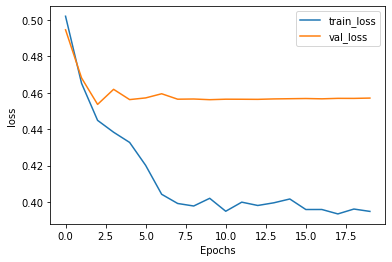

In [83]:
plot_graphs(history, "loss")

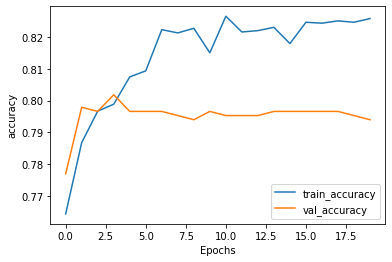

In [84]:
plot_graphs(history, "accuracy")

In [85]:
# Plot the loss VS LR
# plt.semilogx(history.history["lr"], history.history["loss"])